In [1]:
from comut import comut
from comut import fileparsers
import palettable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from collections import OrderedDict
%config InlineBackend.figure_format = 'retina'

Linux-5.11.0-17-generic-x86_64-with-debian-bullseye-sid
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
NumPy 1.19.5
SciPy 1.6.0
Scikit-Learn 0.24.1


In [2]:
cols_down=['risk_alelle_freq',
 'Meth_Mean',
 'logFC',
 'positive_correlated_methylation_Yes',
 'promoter_methylated_unknown',
 'triplex_Yes',
 'triplex_unknown',
 'sample_BRCA',
 'sample_KICH',
 'sample_KIRP',
 'sample_STAD',
 'types_o',
 'types_t',
 'types_unknown']
# generated accuracy 0.93

In [2]:
"""
Global functions used in this notebook
"""
def make_list(df,string):
    lists   =list(df[string].drop_duplicates())
    return lists

def annon(df1,string,df2):
    df_annon     =pd.merge(df1,df2,on=string)
    return df_annon

def add_column(df,lists,string,newcolname):
    df[newcolname]  = np.where(df['gene_sym'].isin(lists),'Yes','No')
    return df

def readfile(path,filename):
    df = pd.read_csv(path+filename,header=0,sep='\t',skipinitialspace=True)
    return df

def annotate_features(df,cancer_driver,drugtarget,triplex,promo_methy,SNPS):
    """
    Feature annotation, adding column to de lncRNAs datafrme based on the feature information
    """
    df =add_column(df,cancer_driver,"gene_sym","cancer_driver")
    df =add_column(df,drugtarget,"gene_sym","drug_target")
    df =add_column(df,triplex,"gene_sym","triplex")
    df =add_column(df,promo_methy,"gene_sym","promoter_methylated")
    df =add_column(df,SNPS,"gene_sym","SNPS")
    return df  

def rename_cols(df,oldname,newname):
    df.rename(columns={oldname:newname},inplace=True)
    return df

def outers_join(df1,df2,string):
    df_new = pd.merge(df1, df2, on=string,how="outer")
    return df_new

def label_paths (row):
    if row['Pathway'] == "unknown":
        return 0
    else:
        return 1
    
def percentage_calc(count_ofyes,countofno,question):
    """
    Percentage calculator for the number of pathways
    """
    pct_of_no_sub = countofno/(countofno+count_ofyes)
    pct_of_sub    = (count_ofyes)/(countofno+count_ofyes)
    return(print("percentage of lncRNAs without" + question, pct_of_no_sub*100),print("percentage of lncRNAs with"+question, pct_of_sub*100))


In [3]:
def data_preparation(common_de,snps,lncRNAs_ref,common_de_ezh2_h2k27,clc,meth):
    """
    Make the dataframe for the logic regression analysis with all avaliable meta information for the pan cancer common 
    De lncRNAs file
    """
    SNPS_ann       = pd.merge(lncRNAs_ref[["gene_id","gene_sym"]],snps_all[["gene_id","p-Value"]],on="gene_id")
    SNPS_ann       = rename_cols(SNPS_ann,"p-Value","risk_alelle_freq")
    SNPS_ann.drop_duplicates(inplace=True)
    SNPS_ann_de    = pd.merge(common_de['gene_sym'],SNPS_ann[["risk_alelle_freq","gene_sym"]],on='gene_sym')
    SNPS_ann_de['risk_alelle_freq'] = pd.to_numeric(SNPS_ann_de['risk_alelle_freq'], errors='coerce')
    SNPS_ann_de.fillna(0, inplace=True)
    SNPS_ann_de    = SNPS_ann_de.sort_values(by='risk_alelle_freq', ascending=False)
    SNPS_ann_de.drop_duplicates(subset='gene_sym', keep="first",inplace=True)
    chrom_de_ezh2  = common_de_ezh2_h2k27.query('chromatin=="EZH2"')
    chrom_de_H3K27 = common_de_ezh2_h2k27.query('chromatin=="H3K27"')
    chrom_de_H3K27 = chrom_de_H3K27[["gene_sym","sample","logFC_chromatin"]]
    chrom_de_ezh2  = chrom_de_ezh2[["gene_sym","sample","logFC_chromatin"]]
    clc_de         = pd.merge(common_de['gene_sym'],clc,on='gene_sym')
    brca_meth_de   = pd.merge(common_de[['gene_sym','sample']],Methylated[["gene_sym","Meth_Mean","sample"]],on=['gene_sym','sample'])
    brca_new       = pd.merge(common_de, SNPS_ann_de, on='gene_sym',how="outer")
    brca_new       = outers_join(brca_new,chrom_de_ezh2[["gene_sym","logFC_chromatin"]],"gene_sym")
    brca_new       = outers_join(brca_new,chrom_de_H3K27[["gene_sym","logFC_chromatin"]],"gene_sym")
    brca_new = rename_cols(brca_new,"logFC_chromatin_x","EZH2")
    brca_new = rename_cols(brca_new,"logFC_chromatin_y","H3K27")
    brca_new = outers_join(brca_new,clc_de,"gene_sym")
    brca_new = pd.merge(brca_new, brca_meth_de, on=['gene_sym','sample'],how="outer")
    brca_new.fillna('unknown', inplace=True)
    brca_new.drop(['SNPS'],axis=1,inplace=True)
    return brca_new

In [3]:
refs        = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/Tcga_R/GDCdata/TCGA-BRCA/harmonized/Transcriptome_Profiling/Gene_Expression_Quantification/r_data/reference/Homo_sapiens.GRCh38.97.chr.txt'
ref         = pd.read_csv(refs, sep="\t", header=0,skipinitialspace=True)
lncRNAs_ref = ref.query('biotype == "lncRNA"')
PC_ref      = ref.query('biotype == "protein_coding"')

In [4]:
path                  = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/filtered_results/'
chrompath             = "/home/alva/Documents/lncRNAs_project_2020/MEG3/"
depath                = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/'
methy                 = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/'
cancer_lncRNAs_census = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/autoencoder_lncRNAs/data/'
SNPS                  = "/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/lncRNAs_TCGA/"
pathmeg3              = "/home/alva/Documents/lncRNAs_project_2020/MEG3/"
de                    = "/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/filtered_results/"
cancer_features       = "/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/lnc2cancer/"
sphase                = '/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/Sphase_lncRNAs/'

In [5]:
#http://www.bio-bigdata.net/lnc2cancer/download.html
cancer_clinical   = pd.read_excel(cancer_features+"lncRNA_clinical.xlsx")
cancer_mechanism  = pd.read_excel(cancer_features+"lncRNA(mechanism).xlsx")
cancer_functional = pd.read_excel(cancer_features+"lncRNA(function).xlsx")

In [59]:
common_de           = readfile(path,"commonDE_5cancermetainformation")
pathways            = readfile(path,"cis_onco_pathways_ann_cols")
triplex             = readfile(depath,"tripleFPP_triplex_genecode")
Methylated          = readfile(methy,'methylated_lncRNAs')
clc                 = readfile(cancer_lncRNAs_census,"lncRNA_CLC")
snps_all            = readfile(SNPS,"SNPs_loci_lncRNAs_cancertypes")
de_fc               = readfile(de,"lncRNAs_acrossatleast5cancer")

In [60]:
SNPS_ann       = pd.merge(lncRNAs_ref[["gene_id","gene_sym"]],snps_all[["gene_id","p-Value"]],on="gene_id")
SNPS_ann       = rename_cols(SNPS_ann,"p-Value","risk_alelle_freq")
SNPS_ann.drop_duplicates(inplace=True)
SNPS_ann_de    = pd.merge(common_de['gene_sym'],SNPS_ann[["risk_alelle_freq","gene_sym"]],on='gene_sym')
SNPS_ann_de['risk_alelle_freq'] = pd.to_numeric(SNPS_ann_de['risk_alelle_freq'], errors='coerce')
SNPS_ann_de.fillna(0, inplace=True)
SNPS_ann_de    = SNPS_ann_de.sort_values(by='risk_alelle_freq', ascending=False)
SNPS_ann_de.drop_duplicates(subset='gene_sym', keep="first",inplace=True)

In [61]:
triple =pd.read_csv('/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/meth/de/tripleFPP_triplex_genecode',sep='\t',header=0)
triple.rename(columns={'gene_sym_y':'gene_sym'},inplace=True)

In [62]:
clc = clc[["NAME AS PUBLISHED","Oncogene (o) or Tumour Supp(t)"]]
clc = rename_cols(clc,"NAME AS PUBLISHED","gene_sym")
clc = rename_cols(clc,"Oncogene (o) or Tumour Supp(t)","types")
Methylated           = rename_cols(Methylated,"Gene","gene_sym")
common_de["sample"]  = common_de["filename"].apply(lambda x:x.split("-")[1])
common_de.drop('filename',axis=1,inplace=True)
de_fc["sample"]      = de_fc["filename"].apply(lambda x:x.split("-")[1])
de_fc                = rename_cols(de_fc,"external_gene_name","gene_sym")
de_fc.drop('filename',axis=1,inplace=True)

 Pathway enrichment score data preparation
#calculated all has got significant p-value

In [10]:
%store -r pathways_kegg_eng_ann_great_fil_lnc
#pathways_kegg_eng_ann_great_fil_lnc.drop('SNPS',axis=1,inplace=True)

In [11]:
Pathways   = pathways_kegg_eng_ann_great_fil_lnc[["Pathway","gene_sym",
                                                  "gene_group","num_of_Genes"]].drop_duplicates()

In [12]:
cancer_clinical_use      = cancer_clinical[["name","Drug","Circulating","Metastasis","Recurrence"]]
cancer_clinical_use      = rename_cols(cancer_clinical_use,"name","gene_sym")
cancer_clinical_use_common = annon(cancer_clinical_use,"gene_sym",de_fc["gene_sym"])
cancer_clinical_use_common.drop_duplicates(inplace=True)
cancer_clinical_use_common_melt = pd.melt(cancer_clinical_use_common,id_vars='gene_sym')
cancer_clinical_use_common_melt = cancer_clinical_use_common_melt.query('value!="0"')
cols = ['Drug','Circulating','Recurrence','Coding Ability']
cancer_clinical_use_common_melt["col"] = cancer_clinical_use_common_melt['variable'] + '_' + cancer_clinical_use_common_melt['value'].astype(str)
cancer_clinical_use_common_melt = (cancer_clinical_use_common_melt['variable'].str.split(', ')
                    .groupby(cancer_clinical_use_common_melt['gene_sym'])
                    .agg(lambda x: ', '.join(set(y for z in x for y in z)))
                    .reset_index())
cancer_clinical_use_common_melt['variable'] =cancer_clinical_use_common_melt['variable'].apply(lambda x: x.replace(',','_'))
cancer_clinical_use_common_melt.gene_sym.drop_duplicates().shape

/home/alva/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(370,)

In [13]:
triple_de = pd.merge(triple[["score","gene_sym"]],common_de["gene_sym"],on='gene_sym')
triple_de.drop_duplicates(inplace=True)

In [14]:
pathways_fc_de = annon(de_fc[["logFC","gene_sym","sample"]],"gene_sym",Pathways)
brca_meth_de   = pd.merge(common_de[['gene_sym','sample']], Methylated[["gene_sym","Meth_Mean","sample"]],on=['gene_sym','sample'])

In [17]:
pathways_fc_de.shape

(34373, 6)

Input Pathways for fisher exact test 

In [15]:
pathways_lncRNAs = (pathways_fc_de['gene_sym'].str.split(', ')
                    .groupby(pathways_fc_de['Pathway'])
                    .agg(lambda x: ', '.join(set(y for z in x for y in z)))
                    .reset_index())
df1 = pathways_lncRNAs.groupby('Pathway')['gene_sym'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
df1['num_of_lncRNAs'] = df1.gene_sym.str.count(',')+1
df1_ann = annon(pathways_fc_de[["Pathway","gene_group","num_of_Genes"]],"Pathway",df1)
df1_ann = df1_ann.drop_duplicates()
df1_ann = df1_ann.query('num_of_lncRNAs<=gene_group')

In [26]:
%store df1_ann

Stored 'df1_ann' (DataFrame)


In [16]:
cancer_mechanism_use = cancer_mechanism[["name","TF","Enhancer","Variant"]]
cancer_mechanism_use = rename_cols(cancer_mechanism_use,"name","gene_sym")
cancer_mechanism_use_common = annon(cancer_mechanism_use,"gene_sym",de_fc["gene_sym"])
cancer_mechanism_use_common.drop_duplicates(inplace=True)
cancer_mechanism_use_common_melt = pd.melt(cancer_mechanism_use_common,id_vars='gene_sym')
cancer_mechanism_use_common_melt['variable'].drop_duplicates()
cancer_mechanism_use_common_melt = cancer_mechanism_use_common_melt.query('value!="0"')
cancer_mechanism_use_common_melt["col"] = cancer_mechanism_use_common_melt['variable'] + '_' + cancer_mechanism_use_common_melt['value'].astype(str)
cancer_mechanism_use_common_melt=cancer_mechanism_use_common_melt.query('col !="TF_0"')
cancer_mechanism_use_common_melt=cancer_mechanism_use_common_melt.query('col !="Enhancer_0"')
cancer_mechanism_use_common_melt=cancer_mechanism_use_common_melt.query('col !="Variant_0"')
cancer_mechanism_use_common_melt = (cancer_mechanism_use_common_melt['variable'].str.split(', ')
                    .groupby(cancer_mechanism_use_common_melt['gene_sym'])
                    .agg(lambda x: ', '.join(set(y for z in x for y in z)))
                    .reset_index())
cancer_mechanism_use_common_melt['variable'] =cancer_mechanism_use_common_melt['variable'].apply(lambda x: x.replace(',','_'))
cancer_mechanism_use_common_melt.drop_duplicates(inplace=True)
cancer_mechanism_use_common_melt.shape

(115, 2)

In [18]:
cancer_functional_use = cancer_functional[["name","autophagy/Apoptosis","Cell Growth","EMT","Survival"]]
cancer_functional_use = rename_cols(cancer_functional_use,"name","gene_sym")
cancer_functional_use_common      = annon(cancer_functional_use,"gene_sym",de_fc["gene_sym"])
cancer_functional_use_common.drop_duplicates(inplace=True)
cancer_functional_use_common_melt = pd.melt(cancer_functional_use_common,id_vars='gene_sym')
cancer_functional_use_common_melt.drop_duplicates(inplace=True)
#cancer_functional_use_common_melt['value'] = pd.to_numeric(cancer_functional_use_common_melt['value'])
cancer_functional_use_common_melt_fil        = cancer_functional_use_common_melt.query('value!="0" ')
cancer_functional_use_common_melt_fil["col"] = cancer_functional_use_common_melt_fil['variable'] + '_' + cancer_functional_use_common_melt_fil['value'].astype(str)
cancer_functional_use_common_melt_fil=cancer_functional_use_common_melt_fil.query('col !="Cell Growth_0"')
cancer_functional_use_common_melt_fil =cancer_functional_use_common_melt_fil.query('col != "autophagy/Apoptosis_autophagy0"')
cancer_functional_use_common_melt_fil =cancer_functional_use_common_melt_fil.query('col != "EMT_0"')
cancer_functional_use_common_melt_fil =cancer_functional_use_common_melt_fil.query('col !="Survival_0"')
cancer_functional_use_common_melt_fil = (cancer_functional_use_common_melt_fil['variable'].str.split(', ')
                    .groupby(cancer_functional_use_common_melt_fil['gene_sym'])
                    .agg(lambda x: ', '.join(set(y for z in x for y in z)))
                    .reset_index())
cancer_functional_use_common_melt_fil['variable'] =cancer_functional_use_common_melt_fil['variable'].apply(lambda x: x.replace(',','_'))
cancer_functional_use_common_melt_fil.drop_duplicates(inplace=True)
cancer_functional_use_common_melt_fil.shape

/home/alva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(320, 2)

In [19]:
sphase_lncRNAs    = readfile(sphase,"Sphase_TCGA")
sphase_lncRNAs["sphase_mean_FC"]    = sphase_lncRNAs[["GeneSymbol","S-phase T1","S-phase T2","S-phase T3"]].mean(axis=1)
sphase_lncRNAs    = rename_cols(sphase_lncRNAs,"GeneSymbol","gene_sym")

In [20]:
common_de.columns

Index(['gene_sym', 'proximal_cancer_driver', 'proximal_drug_target', 'triplex',
       'promoter_methylated', 'SNPS', 'negative_correlated_methylation',
       'positive_correlated_methylation', 'sample'],
      dtype='object')

1.New data preparation as of March 18th

In [64]:
clc_de    = pd.merge(common_de['gene_sym'],clc,on='gene_sym')
clc_de.drop_duplicates(inplace=True)
meth_de   = pd.merge(common_de[['gene_sym','sample']],Methylated[["gene_sym","Meth_Mean","sample"]],on=['gene_sym','sample'])
meth_de.drop_duplicates(inplace=True)
sphase_de = pd.merge(common_de['gene_sym'],sphase_lncRNAs[["gene_sym","sphase_mean_FC"]],on='gene_sym')
sphase_de.drop_duplicates(inplace=True)

In [65]:
common_de = outers_join(common_de,clc_de,"gene_sym")
common_de = outers_join(common_de,meth_de,["gene_sym","sample"])
common_de = outers_join(common_de,sphase_de,"gene_sym")
common_de = outers_join(common_de,triple_de,"gene_sym")
common_de = annon(de_fc[["gene_sym","logFC","sample"]],["gene_sym","sample"],common_de)
common_de.drop_duplicates(inplace=True)

In [66]:
common_de = outers_join(common_de,cancer_mechanism_use_common_melt[["gene_sym","variable"]],"gene_sym")
common_de = rename_cols(common_de,"variable","mechanism")

In [67]:
common_de = outers_join(common_de,cancer_functional_use_common_melt_fil[["gene_sym","variable"]],"gene_sym")
common_de = rename_cols(common_de,"variable","functional")

In [68]:
common_de = outers_join(common_de,cancer_clinical_use_common_melt[["gene_sym","variable"]],"gene_sym")
common_de = rename_cols(common_de,"variable","clinical")
common_de.fillna("0",inplace=True)
common_de.drop_duplicates(inplace=True)
common_de.shape
#common_de.drop(['Pathway_x','Pathway_y'],axis=1,inplace=True)

(26467, 17)

In [56]:
common_de

,gene_sym,logFC,sample,proximal_cancer_driver,proximal_drug_target,triplex,promoter_methylated,SNPS,negative_correlated_methylation,positive_correlated_methylation,types,Meth_Mean,sphase_mean_FC,score,mechanism,functional,clinical
0,A1BG-AS1,-1.277354,COAD,No,No,No,No,No,No,No,0,0,0,0,0,0,Recurrence_ Metastasis
1,A1BG-AS1,0.988639,HNSC,No,No,No,No,No,No,No,0,0,0,0,0,0,Recurrence_ Metastasis
2,A1BG-AS1,-1.049325,KICH,No,No,No,No,No,No,No,0,0,0,0,0,0,Recurrence_ Metastasis
3,A1BG-AS1,-0.772376,LIHC,No,No,No,No,No,No,No,0,0,0,0,0,0,Recurrence_ Metastasis
4,A1BG-AS1,-0.581519,LUAD,No,No,No,No,No,No,No,0,0,0,0,0,0,Recurrence_ Metastasis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26462,ZSCAN16-AS1,-0.670712,COAD,No,No,No,No,No,No,No,0,0,0,0,0,0,0
26463,ZSCAN16-AS1,-0.968157,KICH,No,No,No,No,No,No,No,0,0,0,0,0,0,0
26464,ZSCAN16-AS1,-0.778585,KIRC,No,No,No,No,No,No,No,0,0,0,0,0,0,0
26465,ZSCAN16-AS1,-0.642760,LUAD,No,No,No,No,No,No,No,0,0,0,0,0,0,0


In [69]:
common_de = outers_join(common_de,pathways_fc_de[["gene_sym","sample","Pathway","logFC"]],['gene_sym','sample','logFC'])
common_de.fillna('unknown',inplace=True)
common_de.drop_duplicates(inplace=True)
common_de.shape

(72811, 18)

In [70]:
common_de.columns

Index(['gene_sym', 'logFC', 'sample', 'proximal_cancer_driver',
       'proximal_drug_target', 'triplex', 'promoter_methylated', 'SNPS',
       'negative_correlated_methylation', 'positive_correlated_methylation',
       'types', 'Meth_Mean', 'sphase_mean_FC', 'score', 'mechanism',
       'functional', 'clinical', 'Pathway'],
      dtype='object')

In [71]:
path_filtered =['unknown',
 'cAMP',
 'Metabolic',
 'Ras',
 'PI3K-Akt',
 'Pathways',
 'Transcriptional',
 'Rap1',
 'Endocytosis',
 'Focal',
 'Proteoglycans',
 'cGMP-PKG',
 'Axon',
 'Cellular',
 'HIF-1',
 'FoxO',
 'Endocrine',
 'MAPK',
 'ECM-receptor',
 'Wnt',
 'Tight',
 'Signaling',
 'Growth',
 'Glycolysis',
 'Regulation',
 'Adherens',
 'Hedgehog',
 'Hippo',
 'AMPK',
 'Melanogenesis',
 'Gap',
 'TGF-beta']
common_de = common_de[common_de['Pathway'].isin(path_filtered)]

In [72]:
common_de['y']  = common_de.apply(lambda row: label_paths(row), axis=1)
common_de       = pd.merge(common_de, SNPS_ann_de, on='gene_sym',how="outer")
common_de.fillna(0,axis=1,inplace=True)

In [73]:
common_de['Pathway']

0        unknown
1        unknown
2        unknown
3        unknown
4        unknown
          ...   
49632    unknown
49633    unknown
49634    unknown
49635    unknown
49636          0
Name: Pathway, Length: 49637, dtype: object

In [74]:
common_de['Meth_Mean']       =pd.to_numeric(common_de.Meth_Mean, errors='coerce')
common_de['sphase_mean_FC']  =pd.to_numeric(common_de.sphase_mean_FC, errors='coerce')
common_de['risk_alelle_freq']=pd.to_numeric(common_de.risk_alelle_freq, errors='coerce')
common_de['score']           =pd.to_numeric(common_de.score, errors='coerce')
common_de['logFC']           =pd.to_numeric(common_de.logFC, errors='coerce')

In [75]:
Signalling = ['AMPK','Focal','Hedgehog','FoxO','Wnt','Gap','PI3K-Akt','TGF-beta',
              'Hippo','MAPK','Ras','Rap1','Regulation','cGMP-PKG','HIF-1','ECM-receptor','cGMP-PKG','cAMP','Endocrine']
cellular   = ['Endocytosis','Adherens','Glycolysis','Proteoglycans','Cellular']

In [76]:
#common_de.drop('Pathway',axis=1,inplace=True)
common_de.drop('gene_sym',axis=1,inplace=True)
common_de.drop('triplex',axis=1,inplace=True)
#common_de.drop('sample',axis=1,inplace=True)
common_de.drop_duplicates(inplace=True)

In [77]:
common_de[['Pathway']] = common_de[['Pathway']].replace(dict.fromkeys(Signalling, 'Signaling'))
common_de[['Pathway']] = common_de[['Pathway']].replace(dict.fromkeys(cellular, 'Cellular'))


In [78]:
common_de[(common_de == 'Cellular').any(axis=1)]

,logFC,sample,proximal_cancer_driver,proximal_drug_target,promoter_methylated,SNPS,negative_correlated_methylation,positive_correlated_methylation,types,Meth_Mean,sphase_mean_FC,score,mechanism,functional,clinical,Pathway,y,risk_alelle_freq
87,-3.153973,BRCA,No,No,No,No,No,No,0,0.0,2.02,0.0,0,0,0,Cellular,1.0,0.0
89,-3.153973,BRCA,No,No,No,No,No,No,0,0.0,2.02,0.0,0,0,0,Cellular,1.0,0.0
90,0.919768,HNSC,No,No,No,No,No,No,0,0.0,2.02,0.0,0,0,0,Cellular,1.0,0.0
92,0.919768,HNSC,No,No,No,No,No,No,0,0.0,2.02,0.0,0,0,0,Cellular,1.0,0.0
93,2.003736,KICH,No,No,No,No,No,No,0,0.0,2.02,0.0,0,0,0,Cellular,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49307,-0.983622,COAD,No,No,No,No,No,No,0,0.0,0.00,0.0,0,0,0,Cellular,1.0,0.0
49308,-0.769008,ESCA,No,No,No,No,No,No,0,0.0,0.00,0.0,0,0,0,Cellular,1.0,0.0
49309,-1.431780,KICH,No,No,No,No,No,No,0,0.0,0.00,0.0,0,0,0,Cellular,1.0,0.0
49310,-1.309923,LUAD,No,No,No,No,No,No,0,0.0,0.00,0.0,0,0,0,Cellular,1.0,0.0


In [79]:
replacement= {"Pathways":"unknown",
              "Axon":"unknown",
               "Tight":"unknown",
                "Growth":"unknown",
                "Melanogenesis":"unknown",
                "Transcriptional":"unknown"}

In [80]:
#test['Pathway'] = test.apply(rename_vals,axis=1)
common_de['Pathway'] = common_de['Pathway'].replace(replacement, regex=True)


In [60]:
%store common_de

Stored 'common_de' (DataFrame)


In [38]:
common_de.Pathway.drop_duplicates()

0          unknown
18       Signaling
23       Metabolic
87        Cellular
49636            0
Name: Pathway, dtype: object

In [43]:
BRCA = common_de.query('sample =="BRCA"')
BRCA

,logFC,sample,proximal_cancer_driver,proximal_drug_target,promoter_methylated,SNPS,negative_correlated_methylation,positive_correlated_methylation,types,Meth_Mean,sphase_mean_FC,score,mechanism,functional,clinical,y,risk_alelle_freq
9,-1.307162,BRCA,No,No,No,No,No,No,0,0.0,0.666667,0.0,0,Survival_ Cell Growth,Recurrence_ Metastasis,0.0,0.0
18,-1.693635,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,1.0,0.0
23,0.668899,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,1.0,0.0
58,-0.689454,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,1.0,0.0
69,-1.296427,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49543,-1.168064,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,0.0,0.0
49558,-1.154551,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,0.0,0.0
49568,-1.212904,BRCA,No,No,No,No,No,No,0,0.0,0.000000,0.0,TF,EMT_ Survival_ Cell Growth,Recurrence_ Drug_ Metastasis,0.0,0.0
49577,-0.918857,BRCA,Yes,No,No,No,No,No,0,0.0,0.000000,0.0,0,0,0,1.0,0.0


Old Data preparations

In [ ]:
EZH2  = readfile(pathmeg3,"EZH2_enriched_lncRNAs")
EZH2  = rename_cols(EZH2,"GeneSymbol","gene_sym")
H3K27 = readfile(pathmeg3,"H3k27_enriched_lncRNAs")
H3K27 = rename_cols(H3K27,"GeneSymbol","gene_sym")
common_de_EZH2       = pd.merge(de_fc[["gene_sym","logFC","sample"]],EZH2[["gene_sym","logFC"]],on="gene_sym",suffixes=('_de', '_chromatin'))
common_de_EZH2["chromatin"] = "EZH2"
common_de_H3K27      = pd.merge(de_fc[["gene_sym","logFC","sample"]],H3K27[["gene_sym","logFC"]],on="gene_sym",suffixes=('_de', '_chromatin'))
common_de_H3K27["chromatin"] = "H3K27"
common_de_ezh2_h2k27 = pd.concat([common_de_H3K27,common_de_EZH2])
common_de_melt      = pd.melt(common_de,id_vars=['gene_sym','sample'],var_name='category',value_name='value')
common_de_data      = common_de_melt[["gene_sym","sample"]]
#common_de_data     = pd.merge(common_de_data,pathways,on="gene_sym")
common_de_data

In [ ]:
common_de_new  = data_preparation(common_de,snps_all,lncRNAs_ref,common_de_ezh2_h2k27,clc,Methylated)
common_de_new  = pd.merge(common_de_new,de_fc[["logFC","sample","gene_sym"]],on=['gene_sym',"sample"])
common_de_new  = pd.merge(common_de_new, common_de[["gene_sym","Pathway","sample"]], on=['gene_sym','sample'],how="outer")
common_de_new.fillna('unknown', inplace=True)
common_de_new["pathway_y"]   = common_de_new.apply(lambda row: label_paths(row), axis=1)
common_de_new                = common_de_new.replace("No","unknown")
num_cols                     = ['EZH2', 'H3K27','logFC','Meth_Mean','risk_alelle_freq','pathway_y']
common_de_new[num_cols]      = common_de_new[num_cols].apply(pd.to_numeric, errors='coerce')

In [1]:
common_de_new = common_de_new.drop_duplicates()

NameError: name 'common_de_new' is not defined

In [521]:
common_de_new['Meth_Mean'].fillna(0,inplace=True)
common_de_new['EZH2'].fillna(0,inplace=True)
common_de_new['H3K27'].fillna(0,inplace=True)
common_de_new['risk_alelle_freq'].fillna(0,inplace=True)

In [522]:
%store common_de_new

Stored 'common_de_new' (DataFrame)


In [523]:
common_de_new.risk_alelle_freq

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19583    0.0
19584    0.0
19585    0.0
19586    0.0
19587    0.0
Name: risk_alelle_freq, Length: 14294, dtype: float64

Data exploration

In [31]:
common_de_new[["gene_sym","Pathway"]].drop_duplicates().shape

(3379, 2)

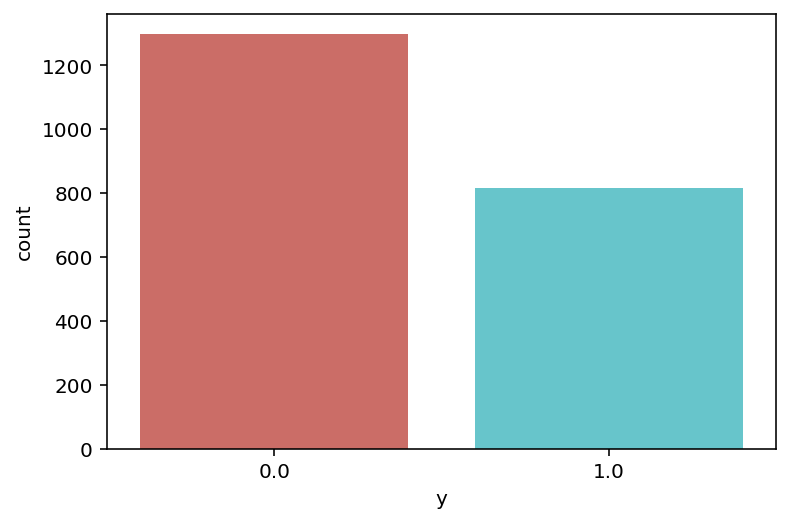

In [44]:
sns.countplot(data=BRCA,x='y',palette='hls')
plt.show()
#plt.savefig("commonDe_pathway.png")

In [463]:
common_de_new.groupby('pathway_y').mean()
common_de_new.groupby('Pathway').mean()

,risk_alelle_freq,EZH2,H3K27,Meth_Mean,logFC,count,pathway_y
Pathway,,,,,,,
"Acute myeloid leukemia, PPAR signaling pathway, MAPK signaling pathway, Breast cancer, Leukocyte transendothelial migration, Pathways in cancer, Rap1 signaling pathway, Cell cycle, Cell adhesion molecules, Regulation of actin cytoskeleton, DNA replication, Axon guidance, Small cell lung cancer, Proteoglycans in cancer, Hippo signaling pathway, Cytokine-cytokine receptor interaction, Transcriptional misregulation in cancer, p53 signaling pathway, PI3K-Akt signaling pathway, TNF signaling pathway",NaN,NaN,NaN,NaN,1.548512,20.0,1
"Acute myeloid leukemia, PPAR signaling pathway, MAPK signaling pathway, Breast cancer, Leukocyte transendothelial migration, Pathways in cancer, Rap1 signaling pathway, Regulation of actin cytoskeleton, Cell adhesion molecules, Cell cycle, DNA replication, Axon guidance, Proteoglycans in cancer, Small cell lung cancer, Cytokine-cytokine receptor interaction, Hippo signaling pathway, Transcriptional misregulation in cancer, p53 signaling pathway, PI3K-Akt signaling pathway, TNF signaling pathway, Calcium signaling pathway",NaN,NaN,NaN,NaN,0.486484,21.0,1
"Acute myeloid leukemia, Transcriptional misregulation in cancer, Cell adhesion molecules, Proteoglycans in cancer, MAPK signaling pathway, PI3K-Akt signaling pathway, Axon guidance, Calcium signaling pathway, Pathways in cancer",NaN,NaN,NaN,NaN,-0.645642,9.0,1
"Acute myeloid leukemia, Transcriptional misregulation in cancer, Cell cycle, Regulation of actin cytoskeleton, p53 signaling pathway, Small cell lung cancer, Breast cancer, DNA replication, MAPK signaling pathway, Pathways in cancer",NaN,NaN,NaN,NaN,2.243343,10.0,1
"Acute myeloid leukemia, Transcriptional misregulation in cancer, Cell cycle, Regulation of actin cytoskeleton, p53 signaling pathway, Small cell lung cancer, DNA replication, PI3K-Akt signaling pathway, Pathways in cancer",NaN,NaN,NaN,NaN,1.438246,9.0,1
...,...,...,...,...,...,...,...
p53 signaling pathway,NaN,NaN,NaN,NaN,0.950766,1.0,1
"p53 signaling pathway, Small cell lung cancer, Breast cancer, PI3K-Akt signaling pathway, Pathways in cancer",NaN,NaN,NaN,NaN,-1.514867,5.0,1
"p53 signaling pathway, Small cell lung cancer, MAPK signaling pathway, TNF signaling pathway, Pathways in cancer",NaN,NaN,NaN,NaN,1.169474,5.0,1


KeyError: 'Acute myeloid leukemia, PPAR signaling pathway, MAPK signaling pathway, Breast cancer, Leukocyte transendothelial migration, Pathways in cancer, Rap1 signaling pathway, Cell cycle, Cell adhesion molecules, Regulation of actin cytoskeleton, DNA replication, Axon guidance, Small cell lung cancer, Proteoglycans in cancer, Hippo signaling pathway, Cytokine-cytokine receptor interaction, Transcriptional misregulation in cancer, p53 signaling pathway, PI3K-Akt signaling pathway, TNF signaling pathway'

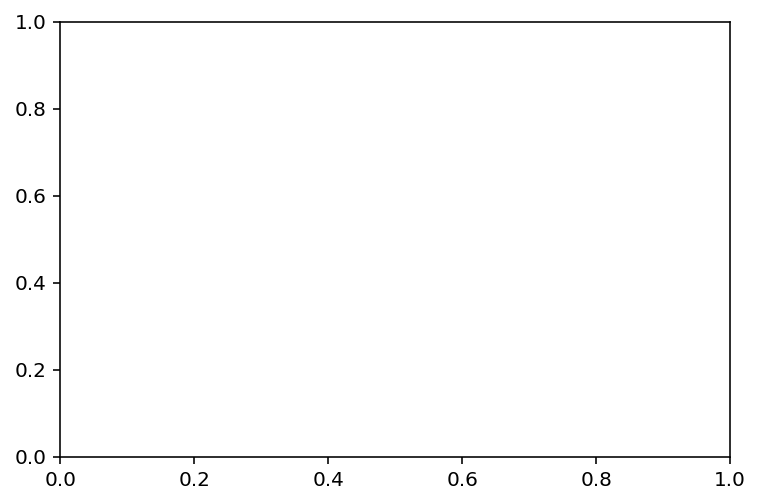

In [464]:
table        = pd.crosstab(common_de_new.types,common_de_new.Pathway)
color        = list('rgbkymc')
color_dict   = {'Cell_Cycle':'red', 'Hippo':'blue', 'MYC':'black', 'NOTCH':'green','NRF2':'purple' ,
              'PI3K':'orange','RTK-RAS':'yellow','TGF-Beta':'hotpink','TP53':'magenta','WNT':'teal','unknown':'aqua'}
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,color=color_dict)
plt.legend(loc='upper left')
plt.title('Stacked Bar Chart of pathway vs oncogenes')
plt.xlabel('oncogene Status')
plt.ylabel('Proportion of pathways')
plt.savefig('pathway_vs_oncogene_stack')

In [201]:
pd.crosstab(common_de_new.types,common_de_new.Pathway).plot(kind='bar',color=color_dict)
plt.title('Pathways Frequency for lncRNAs type')
plt.xlabel('Types')
plt.ylabel('Frequency of Pathways')


NameError: name 'common_de_new' is not defined

In [100]:
table=pd.crosstab(common_de_new.sample,common_de_new.Pathway)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,color=color_dict)
plt.ylabel('Proportion of pathways')

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

Data from notebook 23.improve*

In [33]:
%store -r common_de_fil

In [52]:
keep_samples =['BRCA','KICH','PRAD','STAD','KIRP']

In [39]:
common_de_fil.columns

Index(['score', 'logFC', 'sample', 'proximal_cancer_driver',
       'proximal_drug_target', 'promoter_methylated',
       'negative_correlated_methylation', 'positive_correlated_methylation',
       'types', 'Meth_Mean', 'sphase_mean_FC', 'mechanism', 'functional',
       'clinical', 'y', 'risk_alelle_freq'],
      dtype='object')

<AxesSubplot:ylabel='y'>

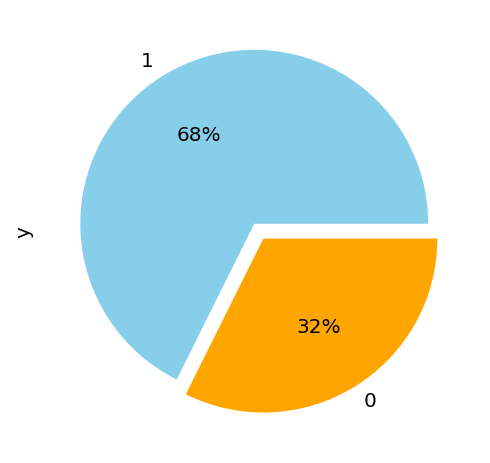

In [35]:
common_de_fil.y.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'],
                                                      explode=(0.05, 0.05))

Selecting Mutual exclusive list of DE up and down lncRNAs

In [56]:
common_DE_5samples = common_de_new[common_de_new['sample'].isin(keep_samples)]

In [2]:
common_DE_5samples

NameError: name 'common_DE_5samples' is not defined

In [58]:
up_de_common   = common_DE_5samples.query('logFC>=0.58')
down_de_common = common_DE_5samples.query('logFC<=-0.58')

In [59]:
common_DE_5samples_up_down = pd.merge(down_de_common,up_de_common, on='gene_sym', how='outer', indicator=True,suffixes=('_up','_down'))

In [60]:
up_alone      = common_DE_5samples_up_down.query('_merge=="left_only"')
down_alone    = common_DE_5samples_up_down.query('_merge=="right_only"')
both_de       = common_DE_5samples_up_down.query('_merge=="both"')
upalone_list  = up_alone.gene_sym.drop_duplicates().tolist()
downalone_list = down_alone.gene_sym.drop_duplicates().tolist()
both_de.gene_sym.drop_duplicates().shape

(1123,)

In [61]:
up_down_alone = downalone_list + upalone_list

In [62]:
common_de_new_down_alone    = common_de_new[common_de_new['gene_sym'].isin(downalone_list)]
common_de_new_up_alone      = common_de_new[common_de_new['gene_sym'].isin(upalone_list)]
common_de_new_up_down_alone = common_de_new[common_de_new['gene_sym'].isin(up_down_alone)]

In [63]:
common_de_new_up_down_alone_BRCA =common_de_new_up_down_alone.query('sample =="BRCA"')

In [64]:
common_de_new_up_down_alone_BRCA

,gene_sym,proximal_cancer_driver,proximal_drug_target,triplex,promoter_methylated,negative_correlated_methylation,positive_correlated_methylation,sample,risk_alelle_freq,EZH2,H3K27,types,Meth_Mean,logFC,Pathway,pathway_y
9,A2M-AS1,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,-1.307162,unknown,0
23,ABALON,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,0.668899,unknown,0
87,AC002116.2,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,0.977489,unknown,0
97,AC002128.1,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,0.583788,unknown,0
114,AC002398.1,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,0.714649,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42811,ZNF426-DT,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,-0.744261,unknown,0
42822,ZNF503-AS1,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,-1.168064,unknown,0
42837,ZNF582-AS1,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,-1.154551,unknown,0
42847,ZNF667-AS1,unknown,unknown,unknown,unknown,unknown,unknown,BRCA,NaN,NaN,NaN,unknown,NaN,-1.212904,unknown,0


<AxesSubplot:ylabel='y'>

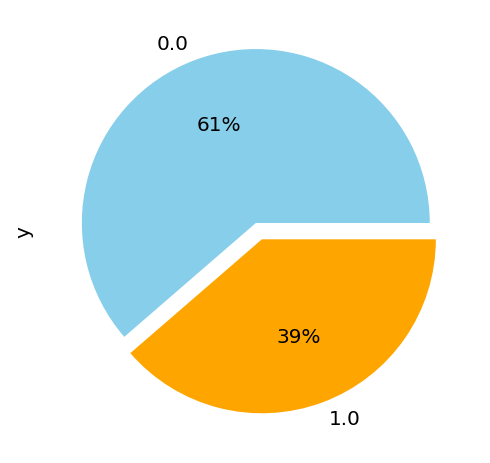

In [45]:
BRCA.y.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'],
                                                      explode=(0.05, 0.05))

Pie chart for pathways and no pathways percentage

<AxesSubplot:ylabel='pathway_y'>

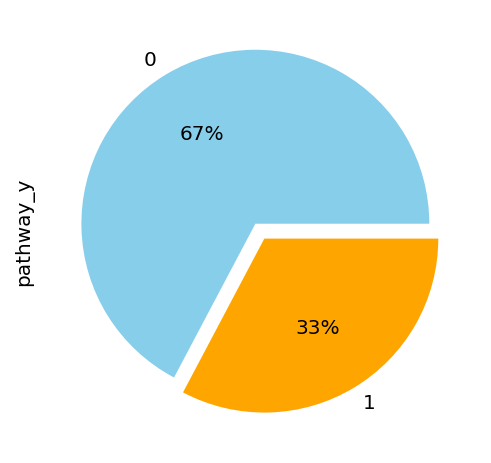

In [349]:
common_de_new.pathway_y.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'],
                                                      explode=(0.05, 0.05))

In [142]:
common_de_new

,gene_sym,proximal_cancer_driver,proximal_drug_target,triplex,promoter_methylated,negative_correlated_methylation,positive_correlated_methylation,sample,risk_alelle_freq,EZH2,H3K27,types,Meth_Mean,logFC,Pathway,pathway_y
0,A1BG-AS1,unknown,unknown,unknown,unknown,unknown,unknown,COAD,0.0,0.0,0.0,unknown,0.0,-1.277354,unknown,0
1,A1BG-AS1,unknown,unknown,unknown,unknown,unknown,unknown,HNSC,0.0,0.0,0.0,unknown,0.0,0.988639,unknown,0
2,A1BG-AS1,unknown,unknown,unknown,unknown,unknown,unknown,KICH,0.0,0.0,0.0,unknown,0.0,-1.049325,unknown,0
3,A1BG-AS1,unknown,unknown,unknown,unknown,unknown,unknown,LIHC,0.0,0.0,0.0,unknown,0.0,-0.772376,unknown,0
4,A1BG-AS1,unknown,unknown,unknown,unknown,unknown,unknown,LUAD,0.0,0.0,0.0,unknown,0.0,-0.581519,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31138,ZSCAN16-AS1,unknown,unknown,unknown,unknown,unknown,unknown,COAD,0.0,0.0,0.0,unknown,0.0,-0.670712,unknown,0
31139,ZSCAN16-AS1,unknown,unknown,unknown,unknown,unknown,unknown,KICH,0.0,0.0,0.0,unknown,0.0,-0.968157,unknown,0
31140,ZSCAN16-AS1,unknown,unknown,unknown,unknown,unknown,unknown,KIRC,0.0,0.0,0.0,unknown,0.0,-0.778585,unknown,0
31141,ZSCAN16-AS1,unknown,unknown,unknown,unknown,unknown,unknown,LUAD,0.0,0.0,0.0,unknown,0.0,-0.642760,unknown,0


In [18]:
common_DE_5samples.gene_sym.drop_duplicates().shape

(3340,)

In [19]:
count_no_pathway   = len(common_DE_5samples[common_DE_5samples['pathway_y']==0])
count_pathway      = len(common_DE_5samples[common_DE_5samples['pathway_y']==1])
count_pathway

9359

In [20]:
percentage_calc(count_pathway,count_no_pathway,"pathway")

percentage of lncRNAs withoutpathway 54.98533019094801
percentage of lncRNAs withpathway 45.014669809051995


(None, None)

Runing the logistic regression model for up and down regulated lncRNAs seperately

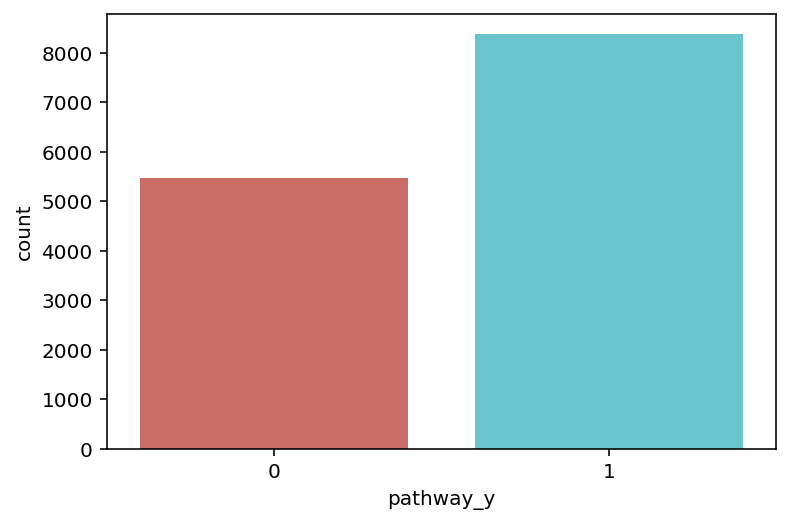

<Figure size 432x288 with 0 Axes>

In [65]:
sns.countplot(data = down_de_common,x='pathway_y',palette='hls')
plt.show()
plt.savefig("down_de_5samples_pathway.png")

In [76]:
pd.crosstab(down_de_common.sample,down_de_common.Pathway).plot(kind='bar',color=color_dict)
plt.title('Pthways in down regulated lncRNAs ')
plt.xlabel('triplex')
plt.ylabel('Frequency of Pathway')


TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

Add filters to the input 22.04.2020

up and down
Randomly >50% features No

0     0.0
18    1.0
Name: y, dtype: float64

In [44]:
common_de.logFC.dtype

dtype('float64')

In [173]:
#test_df = common_de.drop(['y'],axis=1)
test_df = common_de
test_df = test_df.drop_duplicates()
test_df.shape

(32472, 18)

In [174]:
data = test_df
data = data.drop(['Pathway'],axis=1)

data = data.replace(['0',0],0)
data = data.replace(['o','t','ot'],1)

In [145]:
data.shape

(18700, 68)

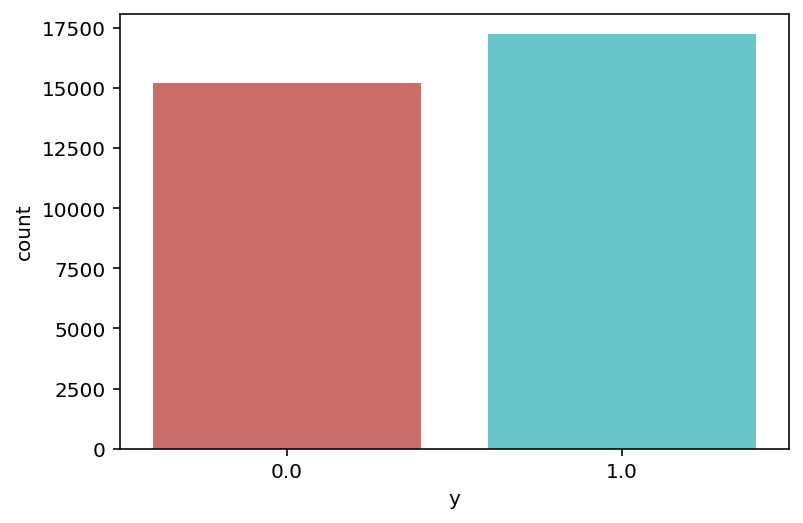

In [175]:
sns.countplot(data = data,x='y',palette='hls')
plt.show()


Choosing the columns which have categorical values to create a dummy dataframe 
The choosen columns/variables have only two values either yes or no


In [176]:
cat_vars     = ['proximal_cancer_driver','proximal_drug_target',
                'negative_correlated_methylation','positive_correlated_methylation',
                'promoter_methylated','sample','mechanism',
                'functional','clinical','SNPS']
for var in cat_vars:
    cat_list = 'var '+'_'+ var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1    = data.join(cat_list)
    data     = data1
    
cat_vars     = ['proximal_cancer_driver','proximal_drug_target',
               'negative_correlated_methylation','positive_correlated_methylation',
               'promoter_methylated','sample','mechanism', 
               'functional','clinical','SNPS']
data_vars    = data.columns.values.tolist()
to_keep      = [i for i in data_vars if i not in cat_vars]

In [177]:
data_final = data[to_keep]
data_final = data_final.replace(['unknown', 'Yes'], 
                     [0,1])
data_final = data_final.fillna(0)
data_final = data_final.replace('yes',1)
data_final = data_final.replace('TF',1)
data_final = data_final.replace('No',0)
#data_final = data_final.replace('Signaling',1)

In [151]:
data_final.shape

(18700, 58)

In [53]:
%store -r data_final

Creating a balanced sample by using Recurrssive feature elimination method

In [178]:
X  = data_final.loc[:, data_final.columns != 'y']
y  = data_final.loc[:, data_final.columns == 'y']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [154]:
y.shape

(18700, 1)

See what is train and  test

In [55]:
print("train x: ", X_train.shape,
      "test x:", X_test.shape,"\n", 
      "train y:", y_train.shape, "\n",
      "test y:" , y_test.shape),"\n"

train x:  (9639, 58) test x: (4132, 58) 
 train y: (9639, 1) 
 test y: (4132, 1)


(None, '\n')

In [228]:
print("train x: ", X_train.columns,"\n",
      "test x: ",  X_test.columns,"\n", 
      "train y: ", y_train.columns,"\n",
      "test y: " , y_test.columns)

train x:  Index(['gene_sym', 'logFC', 'types', 'Meth_Mean', 'sphase_mean_FC', 'score',
       'risk_alelle_freq', 'proximal_cancer_driver_No',
       'proximal_cancer_driver_Yes', 'proximal_drug_target_No',
       'negative_correlated_methylation_No',
       'negative_correlated_methylation_Yes',
       'positive_correlated_methylation_No',
       'positive_correlated_methylation_Yes', 'promoter_methylated_No',
       'promoter_methylated_Yes', 'sample_BRCA', 'sample_COAD', 'sample_ESCA',
       'sample_HNSC', 'sample_KICH', 'sample_KIRC', 'sample_KIRP',
       'sample_LIHC', 'sample_LUAD', 'sample_LUSC', 'sample_PRAD',
       'sample_STAD', 'sample_THCA', 'mechanism_0', 'mechanism_Enhancer',
       'mechanism_Enhancer_ TF', 'mechanism_Enhancer_ TF_ Variant',
       'mechanism_Enhancer_ Variant', 'mechanism_TF', 'mechanism_TF_ Variant',
       'mechanism_Variant', 'functional_0', 'functional_Cell Growth',
       'functional_EMT', 'functional_EMT_ Cell Growth',
       'functional_EMT_ S

In [141]:
#y_train = y_train.replace(0,'unknown')
y_train.drop_duplicates()

,y
45446,1.0
11221,0.0


In [ ]:
Creating balanced sample using SMOTE on categorical features

In [179]:
columns             = X_train.columns
os_data_X,os_data_y = os.fit_resample(X_train, y_train)

In [180]:
os_data_X = pd.DataFrame(data =os_data_X,columns=columns )
os_data_y = pd.DataFrame(data =os_data_y,columns=['y'])

In [150]:
os_data_y.shape

(15618, 1)

In [ ]:
data_final.to_csv("/home/alva/Documents/lncRNAs_project_2020/Analysis_2021/DNA_methy_tcga/autoencoder_lncRNAs/data/pathways_lncRNAs_de_common5",sep='\t',index=False)

In [181]:
# Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no pathways in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of pathways",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no pathways data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of pathways data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  24182
Number of no pathways in oversampled data 12091
Number of pathways 12091
Proportion of no pathways data in oversampled data is  0.5
Proportion of pathways data in oversampled data is  0.5


In [184]:
data_final_vars=data_final.columns.values.tolist()


In [183]:
y=['Pathway']
X=[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe    = RFE(logreg, 25)
rfe    = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

[False  True False False False  True False False  True False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False False  True False  True  True False False False  True False
 False False False False False  True False False False False False False
 False False False  True  True]
[34  1 33  9 21  1 37 28  1 41 23 36 18 19 35 30 17 39 20 29 40  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 27  1  2 31  1  8  1  1 15 11 16  1 13
  3 26 12 10 25  1 14 24 22  7  5 32  6  4 38  1  1]


/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [142]:
balanced_y

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
10755   NaN
10756   NaN
10757   NaN
10758   NaN
10759   NaN
Name: Pathway, Length: 10760, dtype: float64

In [155]:
balanced_X_without_rfe = os_data_X
balanced_y = os_data_y['y']

In [158]:
balanced_X_without_rfe.shape

(15618, 57)

In [185]:
balanced_X = os_data_X[os_data_X.columns[rfe.support_].tolist()]
balanced_y = os_data_y['Pathway']

KeyError: 'Pathway'

In [156]:
%store balanced_X_without_rfe
%store balanced_y

Stored 'balanced_X_without_rfe' (DataFrame)
Stored 'balanced_y' (Series)


In [248]:
os_data_y['pathway_y']

KeyError: 'pathway_y'

In [186]:
X=os_data_X[os_data_X.columns[rfe.support_].tolist()]
y=os_data_y['y']

In [192]:
X.columns

Index(['types', 'risk_alelle_freq', 'proximal_cancer_driver_Yes',
       'sample_BRCA', 'sample_COAD', 'sample_ESCA', 'sample_HNSC',
       'sample_KICH', 'sample_KIRC', 'sample_KIRP', 'sample_LIHC',
       'sample_LUAD', 'sample_LUSC', 'sample_PAAD', 'sample_PRAD',
       'sample_STAD', 'sample_THCA', 'mechanism_Enhancer',
       'mechanism_Enhancer_ Variant', 'mechanism_TF_ Variant',
       'mechanism_Variant', 'functional_EMT', 'functional_Survival_ EMT',
       'SNPS_No', 'SNPS_Yes'],
      dtype='object')

Implementing the model


In [187]:
import statsmodels.api as sm
logit_model = sm.Logit(y,X)
result      = logit_model.fit()
print(result.summary2())

         Current function value: 0.575210
         Iterations: 35


LinAlgError: Singular matrix

Logistic Regression Model Fitting


In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression(class_weight=None,dual=False, fit_intercept=False,intercept_scaling=1,
                   max_iter=100,multi_class='ovr',n_jobs=1, penalty='l2',random_state=None,solver='liblinear',tol=0.0001,
                  verbose=0,warm_start=False, C = 1.63)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


In [161]:
y_pred

array([0., 0., 0., ..., 1., 1., 1.])

In [227]:
print(X_test.head(),"\n","y test: ",y_test.head())

      risk_alelle_freq  Meth_Mean     logFC  \
9842               0.0   0.000000 -0.767323   
8627               0.0   0.778854 -0.580471   
8636               0.0   0.670390 -2.002334   
5790               0.0   0.670390 -2.002334   
4230               0.0   0.000000 -1.886597   

      positive_correlated_methylation_Yes  promoter_methylated_unknown  \
9842                                    0                            1   
8627                                    0                            1   
8636                                    1                            0   
5790                                    1                            0   
4230                                    0                            1   

      triplex_Yes  triplex_unknown  sample_BRCA  sample_KICH  sample_KIRP  \
9842            0                1            0            1            0   
8627            1                0            0            0            0   
8636            1                0       

In [167]:
logreg.score(X_test, y_test)

0.7025181391378574

In [199]:
print( logreg.intercept_ )


0.0


In [200]:
print(logreg.summary())

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [162]:
print("train x: ", X_train.shape,
      "test x:", X_test.shape,"\n", 
      "train y:", y_train.shape, "test y:" , y_test.shape)

train x:  (76883, 25) test x: (32951, 25) 
 train y: (76883,) test y: (32951,)


Finding whether the test and train has got same rows by looking for the difference

In [140]:
X_test[ ~X_test.isin(X_train)].dropna().shape

(3497, 14)

In [130]:
print("train x: ", X_train.columns,"\n",
      "test x: ",  X_test.columns,"\n", 
      "train y: ", y_train,"\n",
      "test y: " , y_test)

train x:  Index(['risk_alelle_freq', 'Meth_Mean', 'logFC',
       'positive_correlated_methylation_Yes', 'promoter_methylated_unknown',
       'triplex_Yes', 'triplex_unknown', 'sample_BRCA', 'sample_KICH',
       'sample_KIRP', 'sample_STAD', 'types_o', 'types_t', 'types_unknown'],
      dtype='object') 
 test x:  Index(['risk_alelle_freq', 'Meth_Mean', 'logFC',
       'positive_correlated_methylation_Yes', 'promoter_methylated_unknown',
       'triplex_Yes', 'triplex_unknown', 'sample_BRCA', 'sample_KICH',
       'sample_KIRP', 'sample_STAD', 'types_o', 'types_t', 'types_unknown'],
      dtype='object') 
 train y:  825      1
9312     1
6847     1
3326     1
9183     0
        ..
4859     1
3264     1
9845     0
10799    0
2732     0
Name: pathway_y, Length: 8157, dtype: int64 
 test y:  9842     0
8627     1
8636     0
5790     0
4230     0
        ..
10786    0
987      0
9534     1
4487     1
2570     0
Name: pathway_y, Length: 3497, dtype: int64


In [168]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2281   28]
 [1366 1011]]


In [169]:
print(classification_report(y_test,y_pred))

NameError: name 'classification_report' is not defined

Accuracy:  0.7025181391378574


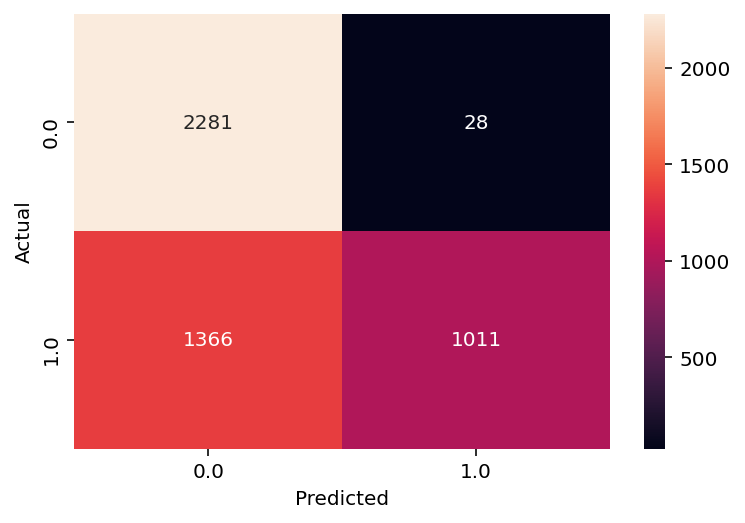

In [170]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
#plt.savefig('5samples_down_regulated.png')

plt.show()

In [171]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.99      0.77      2309
         1.0       0.97      0.43      0.59      2377

    accuracy                           0.70      4686
   macro avg       0.80      0.71      0.68      4686
weighted avg       0.80      0.70      0.68      4686



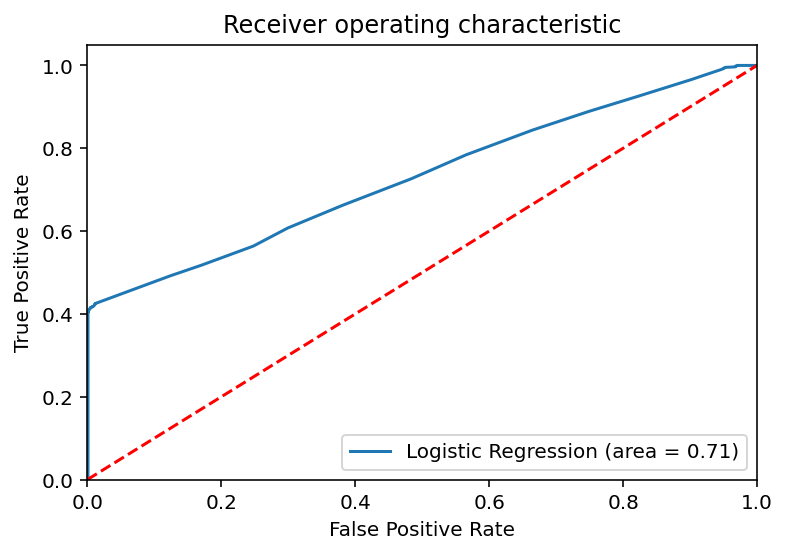

In [172]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC_5samples_down_regulated_with_features.png')
plt.show()